<h1>MBA Upload and Download Speed Metric Charts Multiple Concurrent TCP Connections </h1>

<h5> Andreas Freund </h5>

<h7>acf2175</h7>
<br>

<h7>3/24/22</h7>

In [3]:
# from IPython.core.display import display, HTML
from IPython.display import HTML
from IPython.core.magic import register_cell_magic

@register_cell_magic
def toggle_code(self, cell):
    display(HTML('''
        <script>code_show=true;
        function code_toggle() {
            if (code_show) { $('div.input').hide();}
            else {$('div.input').show();}
            code_show = !code_show
        }
        $(document).ready(code_toggle);
        </script>
        <button onClick="javascript:code_toggle()">Toggle code</button>'''
    ))
    return display(HTML('<p>Click on the button above to show/hide code.</p>'))

In [4]:
# %%toggle_code
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm
from google.cloud import bigquery

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "/Users/andreasfreund/.config/gcloud/application_default_credentials.json"
%load_ext google.cloud.bigquery
client = bigquery.Client()

#setting max rows to print
pd.set_option('display.max_rows', 150)

# style
plt.style.use("fivethirtyeight")
%matplotlib inline




print('Executed')

Executed


<h3> Initial BigQuery SQL Speed Queries </h3>
<p>IPv4 with multiple concurrent TCP connections</p>

<h5>Download Queries and Dataframes</h5>

In [5]:
# DOWNLOAD***

peak_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    --APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        --PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE)) 
    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""

fullDay_download_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        -- PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_download, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_download
) as queryA

JOIN

(SELECT DISTINCT 
    mt_download as download_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_download as INT64)) as _80_80_,
FROM
    (select
        mt.download as mt_download,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httpgetmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))

    ) 
    ORDER BY mt_download
) as queryB

ON queryA.download_service_tier = queryB.download_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech


ORDER BY queryA.download_service_tier, queryA.ISP, queryA.tech

"""


# Creating main dataframes
peak_download = client.query(peak_download_sql).to_dataframe()
fullDay_download = client.query(fullDay_download_sql).to_dataframe()
print("Executed")

Executed


<h5>Upload Queries and Dataframes</h5>


In [6]:
peak_upload_sql = """

SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
        ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE (EXTRACT(HOUR FROM httpmt.dtime) >= 19) AND (EXTRACT(HOUR FROM httpmt.dtime) <=23) AND
            httpmt.ddate < (CAST('2020-10-01' as DATE))    
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech

"""

fullDay_upload_sql = """
SELECT 
queryA.*, 
queryB.* 
FROM

(SELECT DISTINCT
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    avg(httpmt_bytes_sec/125000) as avg_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(50)] as median_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(5)] as low_5_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(95)] as top_95_pct_Mbps,
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(20)] as low_20_pct_Mbps,
    -- APPROX_QUANTILES(_80_pct/125000, 100)[OFFSET(20)] as _80_80_,    
    APPROX_QUANTILES(httpmt_bytes_sec/125000, 100)[OFFSET(16)] as _16_pct_Mbps,
    -- PERCENTILE_CONT(_80_pct,.20) OVER (PARTITION BY mt_ISP, httpmt_unit_id) order by httpmt_bytes_sec , 
    MAX(httpmt_bytes_sec/125000) as max_Mbps,
    MIN(httpmt_bytes_sec/125000) as min_Mbps,
    STDDEV_SAMP(httpmt_bytes_sec/125000) as STD,
    COUNT(DISTINCT httpmt_unit_id) as total_boxes
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
GROUP BY mt_upload, mt_ISP, mt_technology
HAVING COUNT(DISTINCT httpmt_unit_id) > 9
ORDER BY mt_upload
) as queryA

JOIN

(SELECT DISTINCT 
    mt_upload as upload_service_tier,
    mt_ISP as ISP,
    mt_Technology as tech,
    PERCENTILE_CONT(_80_pct/125000,.20) OVER (PARTITION BY mt_ISP, CAST(mt_upload as INT64)) as _80_80_,
FROM
    (select
        mt.upload as mt_upload,
        mt.isp as mt_isp,
        mt.technology as mt_technology,
        httpmt.bytes_sec as httpmt_bytes_sec,
        httpmt.unit_id as httpmt_unit_id,
        PERCENTILE_CONT(httpmt.bytes_sec,.20) OVER (PARTITION BY httpmt.unit_id) as _80_pct
        from
        `broadband-data.mba_data.curr_httppostmt` as httpmt
        INNER JOIN
        `broadband-data.mba_data.unit-profile-sept2020` as mt
        ON httpmt.unit_id=mt.Unit_ID
        WHERE httpmt.ddate < (CAST('2020-10-01' as DATE))
    ) 
    ORDER BY mt_upload
) as queryB

ON queryA.upload_service_tier = queryB.upload_service_tier AND queryA.ISP=queryB.ISP AND queryA.tech= queryB.tech
ORDER BY queryA.upload_service_tier, queryA.ISP, queryA.tech


"""

peak_upload = client.query(peak_upload_sql).to_dataframe()
fullDay_upload = client.query(fullDay_upload_sql).to_dataframe()
print("Executed")

Executed


<h3> Python functions for normalizing dataframes to tiers

In [7]:
def dfNormalizerD(df):
    
    temp = df['download_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']       
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['download_service_tier']

    isp = df['ISP']
    
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty ))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result

def dfNormalizerU(df):
    
    temp = df['upload_service_tier'].astype(int)
    ispTech =  temp.astype(str) +"\n"+ df['ISP'] +"\n"+ df['tech']   
    tech = df['tech']
    avg = df['avg_Mbps']
    median = df['median_Mbps']
    twentypct = df['low_20_pct_Mbps']
    fivepct = df['low_5_pct_Mbps']
    eightyeighty = df['_80_80_']
    tier = df['upload_service_tier']
    isp = df['ISP']
        
    result = pd.DataFrame(dict(tier=tier, ispTech=ispTech, tech=tech, isp=isp, avg = avg, median = median, twentypct = twentypct, 
                               fivepct = fivepct, eightyeighty = eightyeighty))
    
    result['avg'] = (result['avg']/result['tier']) *100
    result['median'] = (result['median']/result['tier']) *100
    result['twentypct'] = (result['twentypct']/result['tier']) *100
    result['fivepct'] = (result['fivepct']/result['tier']) *100
    result['eightyeighty'] = (result['eightyeighty']/result['tier']) *100
    
    return result
    

    




In [8]:
# DSL ISPs: Windstream, Centurylink, Cincinnati Bell
# Cable ISPs: Comcast, Optimum, Mediacom
# Fiber ISPs: Frontier, Verizon, Cincinnati Bell


# Download dataframes
peakDChart = dfNormalizerD(peak_download) 
offPeakDChart = dfNormalizerD(fullDay_download) 

# Peak Download Dataframes by Tech

# Peak Download DSL
peakDDSL = peakDChart.where(peakDChart.tech =='DSL').dropna()
peakDDSL = peakDDSL[(peakDDSL['isp'] =='Windstream') | (peakDDSL['isp'] =='CenturyLink') |
                    (peakDDSL['isp'] =='Cincinnati Bell')]

# Peak Download Cable
peakDCable = peakDChart.where(peakDChart.tech =='Cable').dropna()
peakDCable = peakDCable[(peakDCable['isp'] =='Comcast') | (peakDCable['isp'] =='Optimum') | 
                        (peakDCable['isp'] =='Mediacom')]

# Peak Download Fiber
peakDFiber = peakDChart.where(peakDChart.tech =='Fiber').dropna()
peakDFiber = peakDFiber[(peakDFiber['isp'] =='Frontier') | (peakDFiber['isp'] =='Verizon') | 
                        (peakDFiber['isp'] =='Cincinnati Bell')]




# OffPeak Download Dataframes by Tech

# Fullday Download DSL 
normDDSL = offPeakDChart.where(offPeakDChart.tech =='DSL').dropna()
normDDSL = normDDSL[(normDDSL['isp'] =='Windstream') | (normDDSL['isp'] =='CenturyLink')]


# Fullday Download Cable
normDCable = offPeakDChart.where(offPeakDChart.tech =='Cable').dropna()
normDCable = normDCable[(normDCable['isp'] =='Comcast') | (normDCable['isp'] =='Optimum') | 
                        (normDCable['isp'] =='Mediacom')]


# Fullday Download Fiber
normDFiber = offPeakDChart.where(offPeakDChart.tech =='Fiber').dropna()
normDFiber = normDFiber[(normDFiber['isp'] =='Frontier') | (normDFiber['isp'] =='Verizon')]






# Upload dataframes
peakUChart = dfNormalizerU(peak_upload) 
offPeakUChart = dfNormalizerU(fullDay_upload) 


# Peak Upload Dataframes by tech

# Peak Upload DSL
peakUDSL = peakUChart.where(peakUChart.tech =='DSL').dropna()
peakUDSL = peakUDSL[(peakUDSL['isp'] =='Windstream') | (peakUDSL['isp'] =='CenturyLink')]


# Peak Upload Cable
peakUCable = peakUChart.where(peakUChart.tech =='Cable').dropna()
peakUCable = peakUCable[(peakUCable['isp'] =='Comcast') | (peakUCable['isp'] =='Optimum') | 
                        (peakUCable['isp'] =='Mediacom')]

# Peak Upload Fiber
peakUFiber = peakUChart.where(peakUChart.tech =='Fiber').dropna()
peakUFiber = peakUFiber[(peakUFiber['isp'] =='Frontier') | (peakUFiber['isp'] =='Verizon')]





# OffPeak Upload Dataframes by tech
normUDSL = offPeakUChart.where(offPeakUChart.tech =='DSL').dropna()
normUDSL = normUDSL[(normUDSL['isp'] =='Windstream') | (normUDSL['isp'] =='CenturyLink')]


# Fullday Upload Cable
normUCable = offPeakUChart.where(offPeakUChart.tech =='Cable').dropna()
normUCable = normUCable[(normUCable['isp'] =='Comcast') | (normUCable['isp'] =='Optimum') | 
                        (normUCable['isp'] =='Mediacom')]



# Fullday Upload Fiber
normUFiber = offPeakUChart.where(offPeakUChart.tech =='Fiber').dropna()
normUFiber = normUFiber[(normUFiber['isp'] =='Frontier') | (normUFiber['isp'] =='Verizon')]



In [9]:
# Selected tiers for summary stat chart
dslTiers = peakDDSL[(peakDDSL['tier'] == 25) | (peakDDSL['tier'] == 50) | (peakDDSL['tier'] == 100)]
cableTiers = peakDCable[(peakDCable['tier'] == 25) | (peakDCable['tier'] == 100) | (peakDCable['tier'] == 500)]
fiberTiers = peakDFiber[(peakDFiber['tier'] == 50) | (peakDFiber['tier'] ==100) | (peakDFiber['tier'] == 500)]


In [10]:
# creates selected tier summary chart
frames = [dslTiers, cableTiers, fiberTiers]
selectTierTech = pd.concat(frames)
selectTierTech = selectTierTech.sort_values(by=['tier', 'tech']) 


<hr>

**Chart below used in REPLY TO COMMENT**

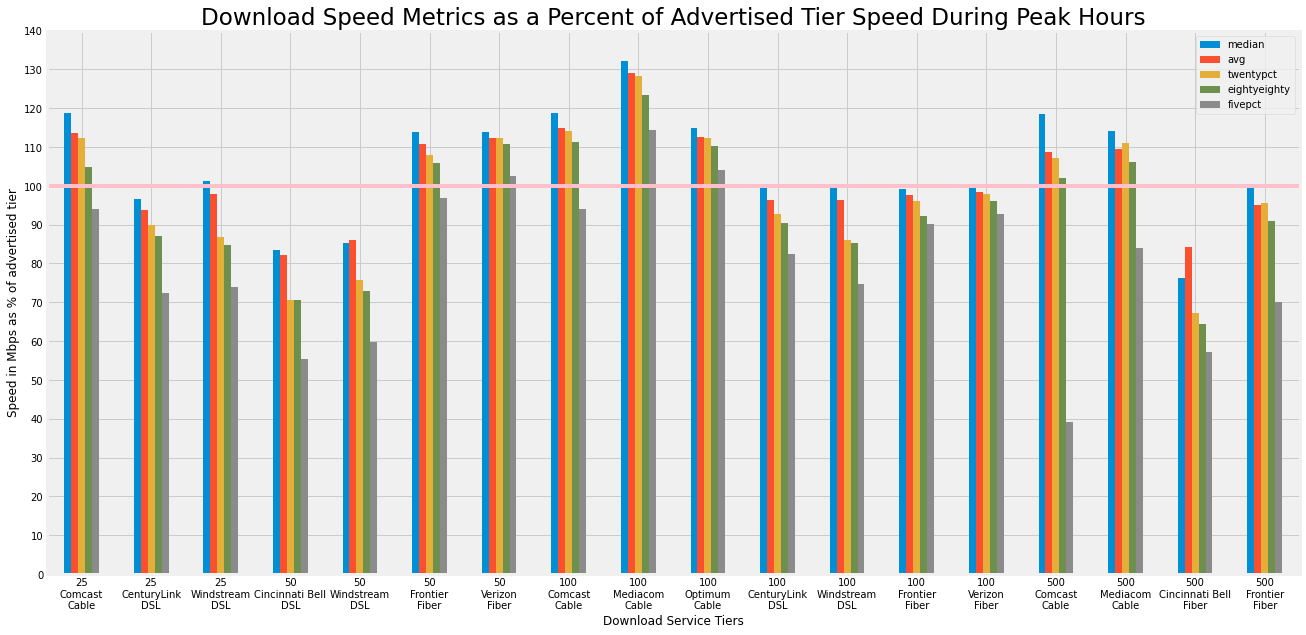

In [11]:
chartData = selectTierTech

ax = chartData.plot(x = "ispTech", y = [ 'median', 'avg', 'twentypct', 'eightyeighty', 'fivepct'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps as % of advertised tier')
ax.set_title('Download Speed Metrics as a Percent of Advertised Tier Speed During Peak Hours', fontsize=23)


plt.show()

<hr>

**Full-day download speed metrics for ex-parte meeting**

In [12]:
dslTiersF = normDDSL[(normDDSL['tier'] == 25) | (normDDSL['tier'] == 50) | (normDDSL['tier'] == 100)]
cableTiersF = normDCable[(normDCable['tier'] == 25) | (normDCable['tier'] == 100) | (normDCable['tier'] == 500)]
fiberTiersF = normDFiber[(normDFiber['tier'] == 50) | (normDFiber['tier'] ==100) | (normDFiber['tier'] == 500)]


In [13]:
# creates selected tier summary chart
framesF = [dslTiersF, cableTiersF, fiberTiersF]
selectTierTechF = pd.concat(framesF)
selectTierTechF = selectTierTechF.sort_values(by=['tier', 'tech']) 


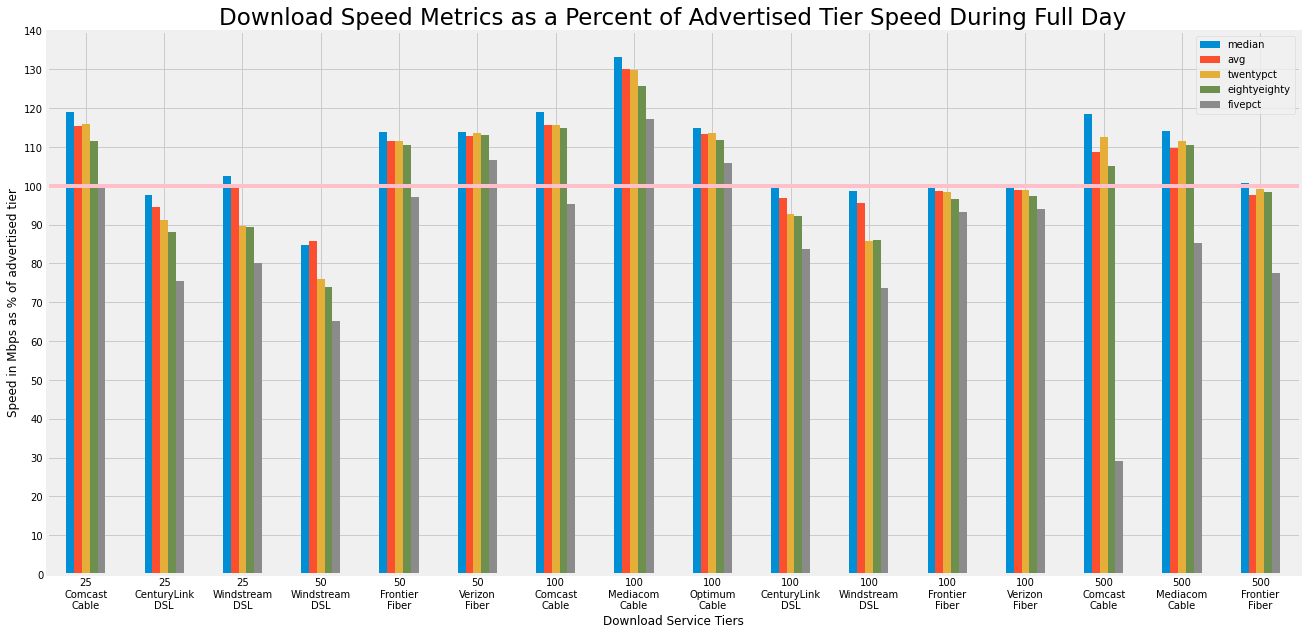

In [14]:
chartData = selectTierTechF

ax = chartData.plot(x = "ispTech", y = [ 'median', 'avg', 'twentypct', 'eightyeighty', 'fivepct'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps as % of advertised tier')
ax.set_title('Download Speed Metrics as a Percent of Advertised Tier Speed During Full Day', fontsize=23)


plt.show()

In [48]:
fullDay5pct = selectTierTech[['ispTech', 'isp', 'tier','tech', 'fivepct']]
peak5pct = selectTierTechF[['ispTech', 'isp','tier', 'tech', 'fivepct']]
chartDataNew = selectTierTech.merge(selectTierTechF, how = 'inner', on=['isp', 'tier', 'tech'])
chartDataNew = chartData.rename(columns = {'ispTech_x': 'ispTech', 
                                        'fivepct_x': 'peak5thPct', 'fivepct_y': 'fullDay5thpct',
                                        'median_x': 'peakMedian', 'median_y': 'fullDayMedian',
                                        'twentypct_x': 'peak20Pct', 'twentypct_y': 'fullDay20Pct'
                                       })
                            
                                        
                                        
                                        
                                        
                                        
                                        
                                        

In [49]:
chartDataNew

,tier,ispTech,tech,isp,avg_x,peakMedian,peak20Pct,peak5thPct,eightyeighty_x,ispTech_y,avg_y,fullDayMedian,fullDay20Pct,fullDay5thpct,eightyeighty_y
0,25.0,25\nComcast\nCable,Cable,Comcast,113.517609,118.789344,112.327424,93.918560,104.899744,25\nComcast\nCable,115.347043,118.887968,115.975392,99.847552,111.485728
1,25.0,25\nCenturyLink\nDSL,DSL,CenturyLink,93.644525,96.482272,89.789536,72.505376,87.130144,25\nCenturyLink\nDSL,94.463914,97.570400,91.251488,75.608832,88.027232
2,25.0,25\nWindstream\nDSL,DSL,Windstream,97.813287,101.123584,86.720128,73.969984,84.770560,25\nWindstream\nDSL,99.593620,102.621824,89.596096,80.229952,89.504486
3,50.0,50\nWindstream\nDSL,DSL,Windstream,85.926683,85.256688,75.698560,59.740992,72.899030,50\nWindstream\nDSL,85.895916,84.765888,75.879344,65.106368,73.897232
4,50.0,50\nFrontier\nFiber,Fiber,Frontier,110.778871,113.884896,108.012432,96.749792,105.912720,50\nFrontier\nFiber,111.548206,113.934080,111.541152,97.174688,110.589776
5,50.0,50\nVerizon\nFiber,Fiber,Verizon,112.421950,113.847504,112.439056,102.622464,110.897334,50\nVerizon\nFiber,112.843972,113.871168,113.549776,106.679808,113.040192
6,100.0,100\nComcast\nCable,Cable,Comcast,114.877088,118.722288,114.138824,93.931080,111.299480,100\nComcast\nCable,115.678639,118.959584,115.735760,95.213296,114.880432
7,100.0,100\nMediacom\nCable,Cable,Mediacom,128.945299,132.226312,128.339272,114.365784,123.349368,100\nMediacom\nCable,130.002889,133.134080,129.872584,117.136080,125.595816
8,100.0,100\nOptimum\nCable,Cable,Optimum,112.618001,114.867000,112.432680,103.979888,110.215424,100\nOptimum\nCable,113.286199,115.008000,113.517056,105.970192,111.748685
9,100.0,100\nCenturyLink\nDSL,DSL,CenturyLink,96.348367,99.504176,92.693632,82.436856,90.504832,100\nCenturyLink\nDSL,96.781226,99.788488,92.791896,83.678272,92.188307


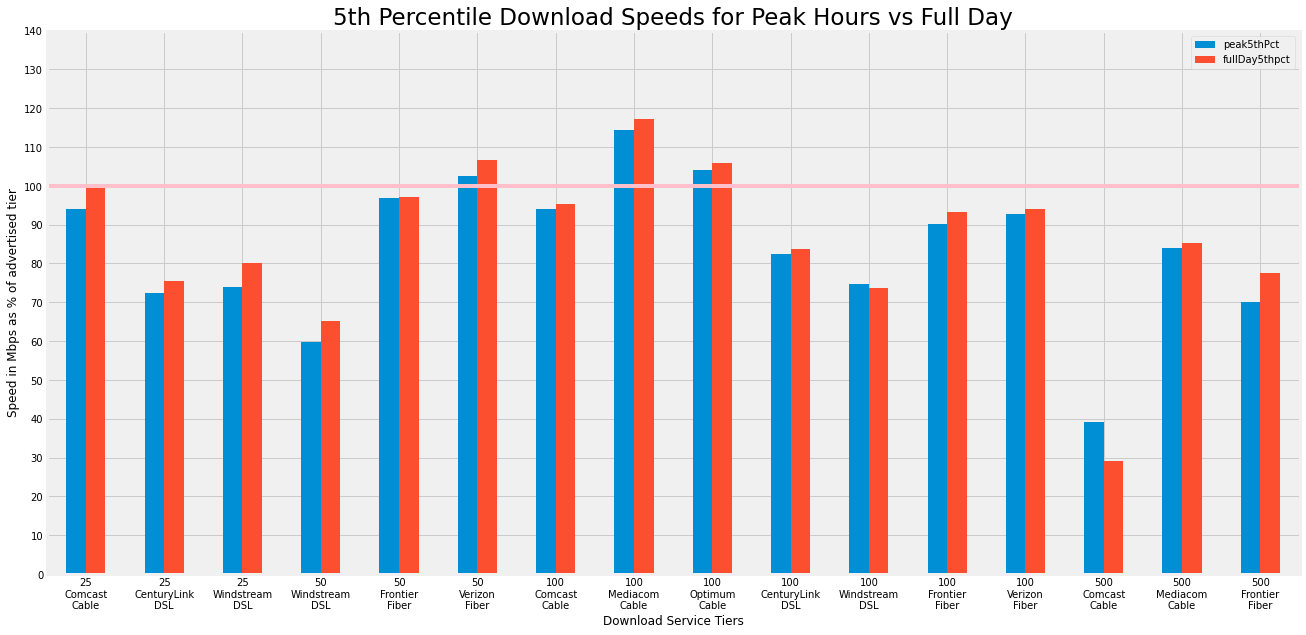

In [50]:


ax = chartDataNew.plot(x = "ispTech", y = [ 'peak5thPct', 'fullDay5thpct'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps as % of advertised tier')
ax.set_title('5th Percentile Download Speeds for Peak Hours vs Full Day', fontsize=23)


plt.show()

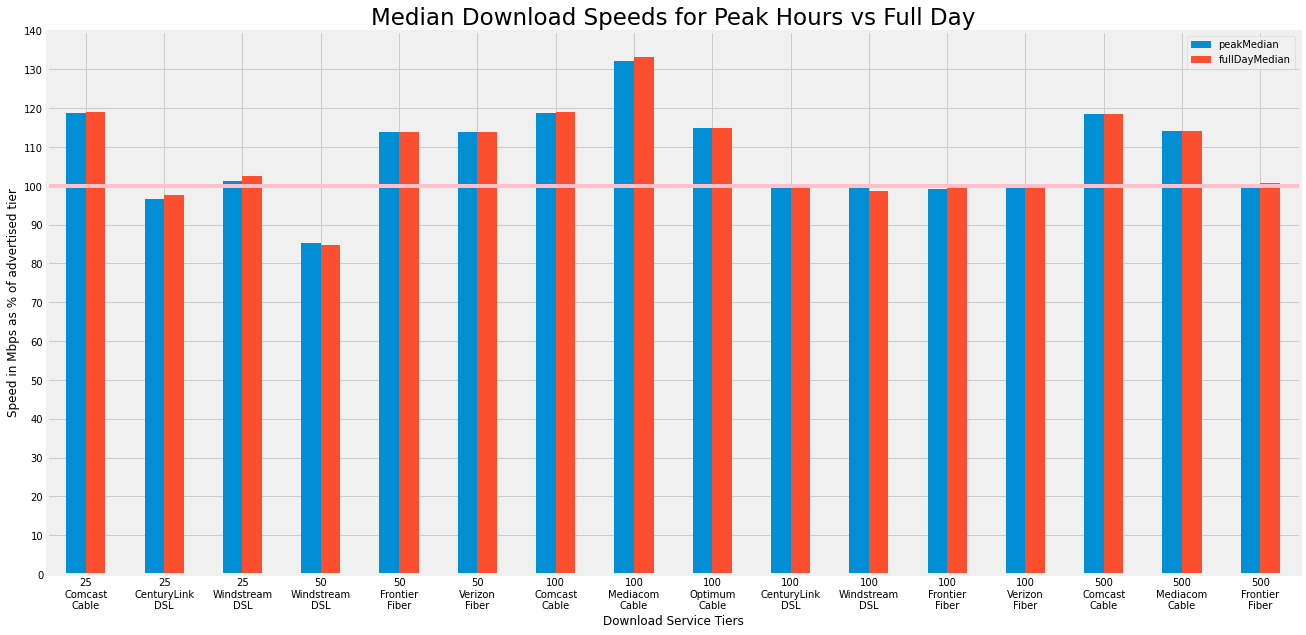

In [51]:
ax = chartDataNew.plot(x = "ispTech", y = [ 'peakMedian', 'fullDayMedian'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps as % of advertised tier')
ax.set_title('Median Download Speeds for Peak Hours vs Full Day', fontsize=23)


plt.show()

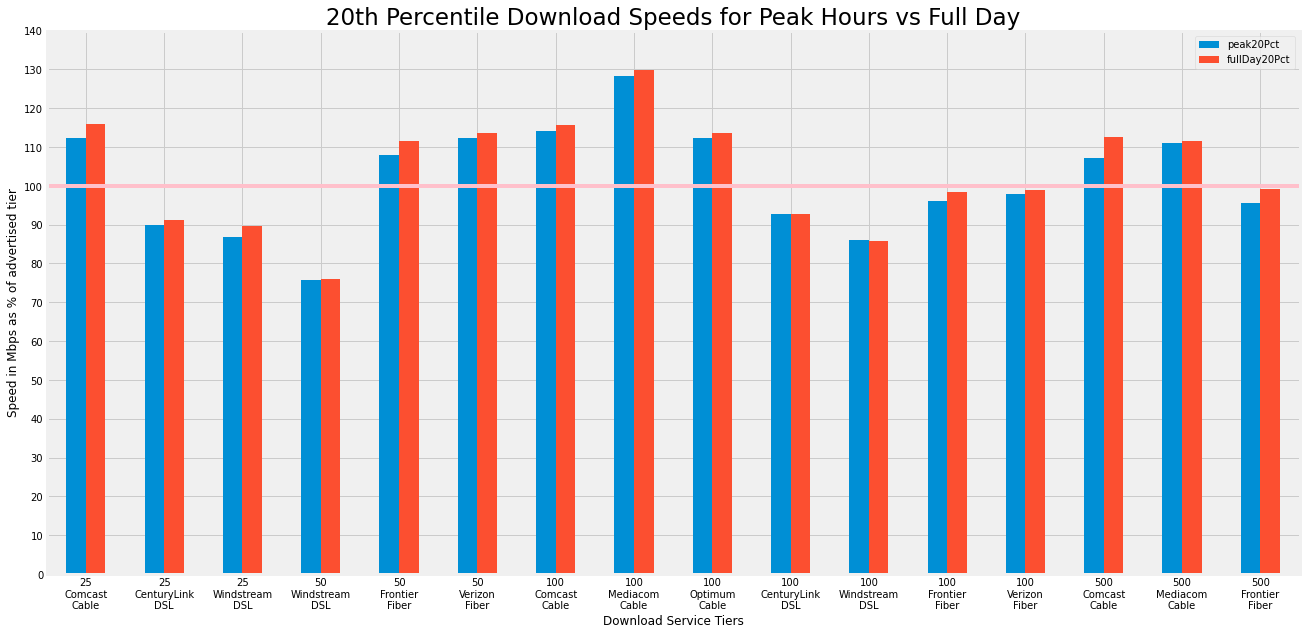

In [52]:
ax = chartDataNew.plot(x = "ispTech", y = [ 'peak20Pct', 'fullDay20Pct'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps as % of advertised tier')
ax.set_title('20th Percentile Download Speeds for Peak Hours vs Full Day', fontsize=23)


plt.show()

<h3> Download Speed Charts

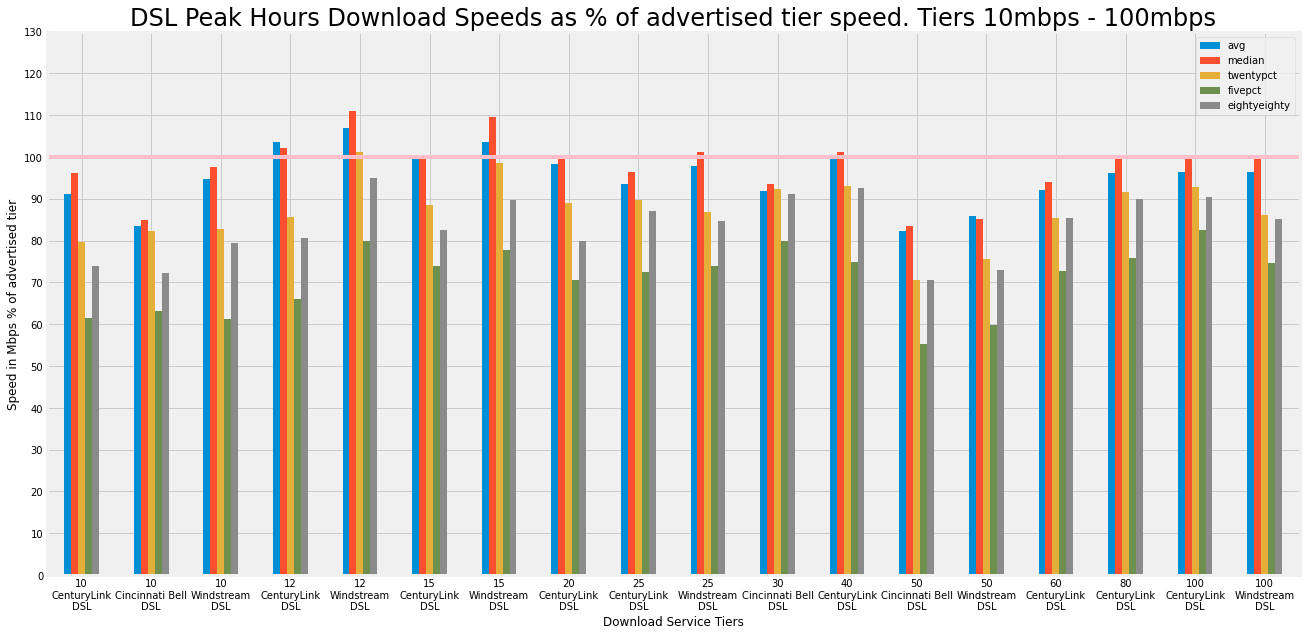

In [22]:
chartData = peakDDSL
chartData = chartData[chartData.tier >= 10]




ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Peak Hours Download Speeds as % of advertised tier speed. Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

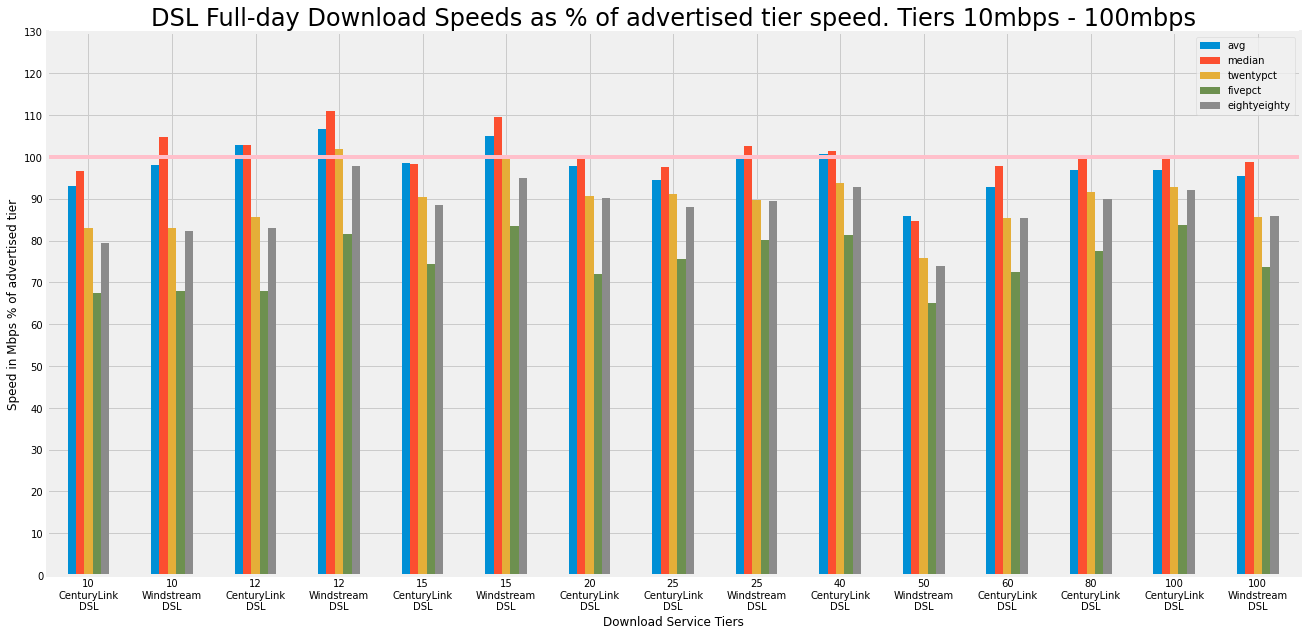

In [23]:
chartData = normDDSL
chartData = chartData[chartData.tier >=10]


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Full-day Download Speeds as % of advertised tier speed. Tiers 10mbps - 100mbps', fontsize=24)


plt.show()

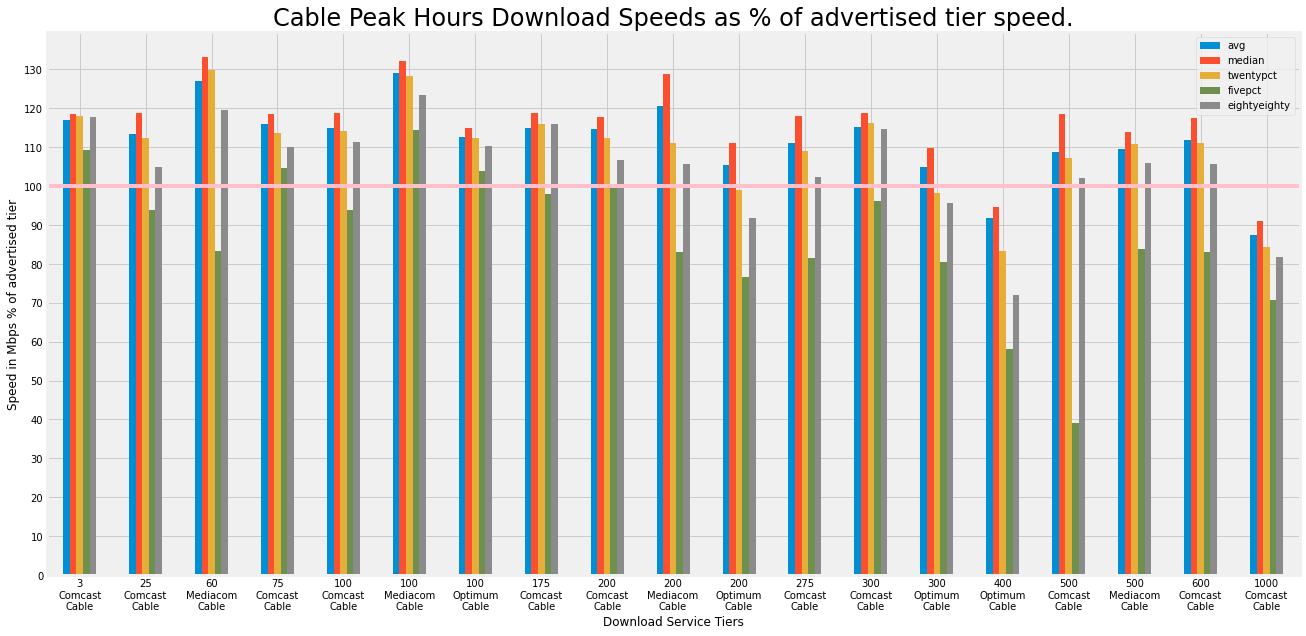

In [24]:
chartData = peakDCable



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)

plt.yticks(np.arange(0, 140, 10))

plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Peak Hours Download Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

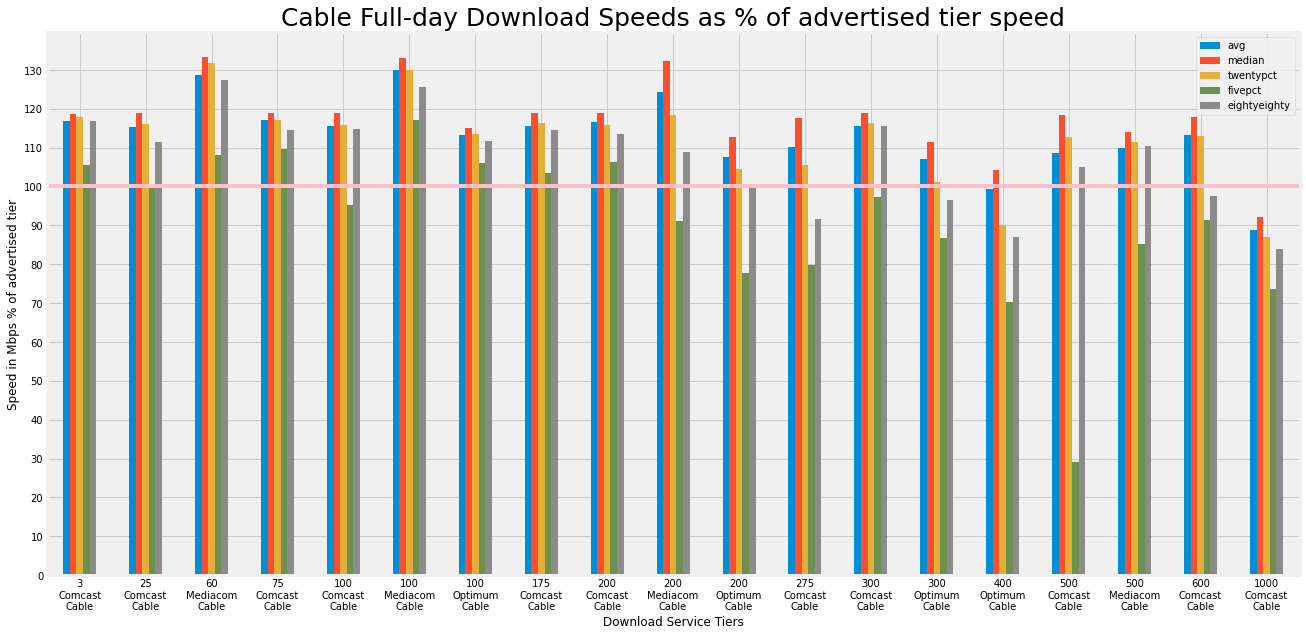

In [25]:
chartData = normDCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Full-day Download Speeds as % of advertised tier speed', fontsize=25)


plt.show()

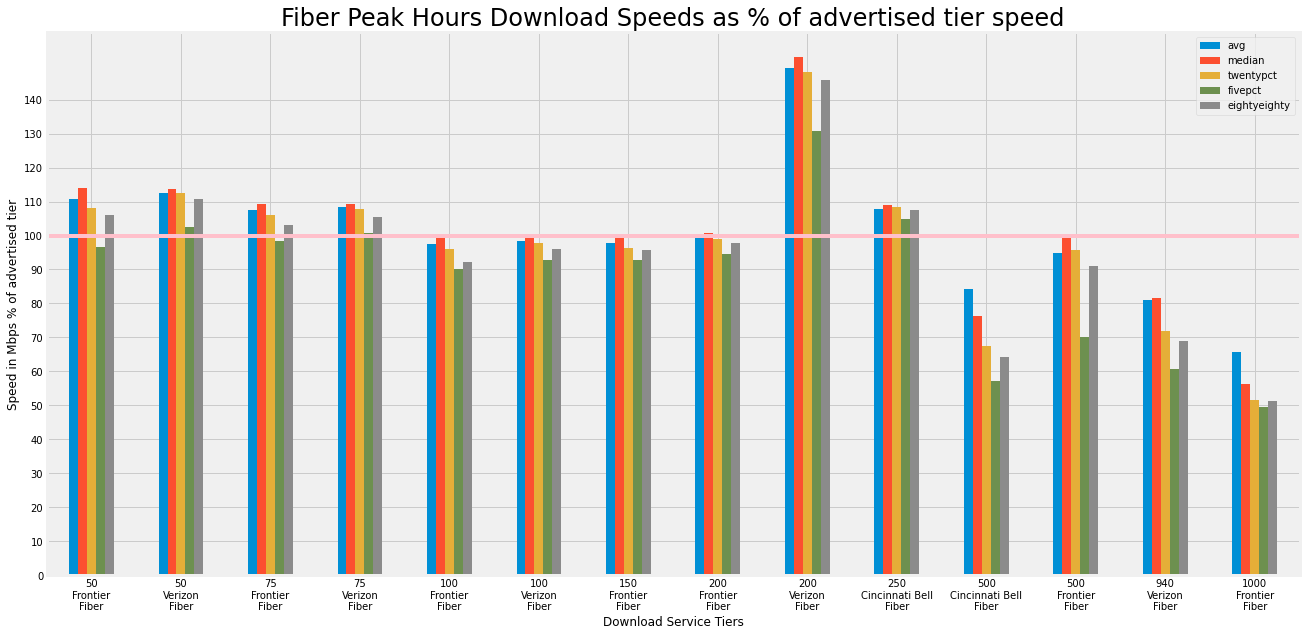

In [26]:
chartData = peakDFiber

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Peak Hours Download Speeds as % of advertised tier speed', fontsize=24)


plt.show()

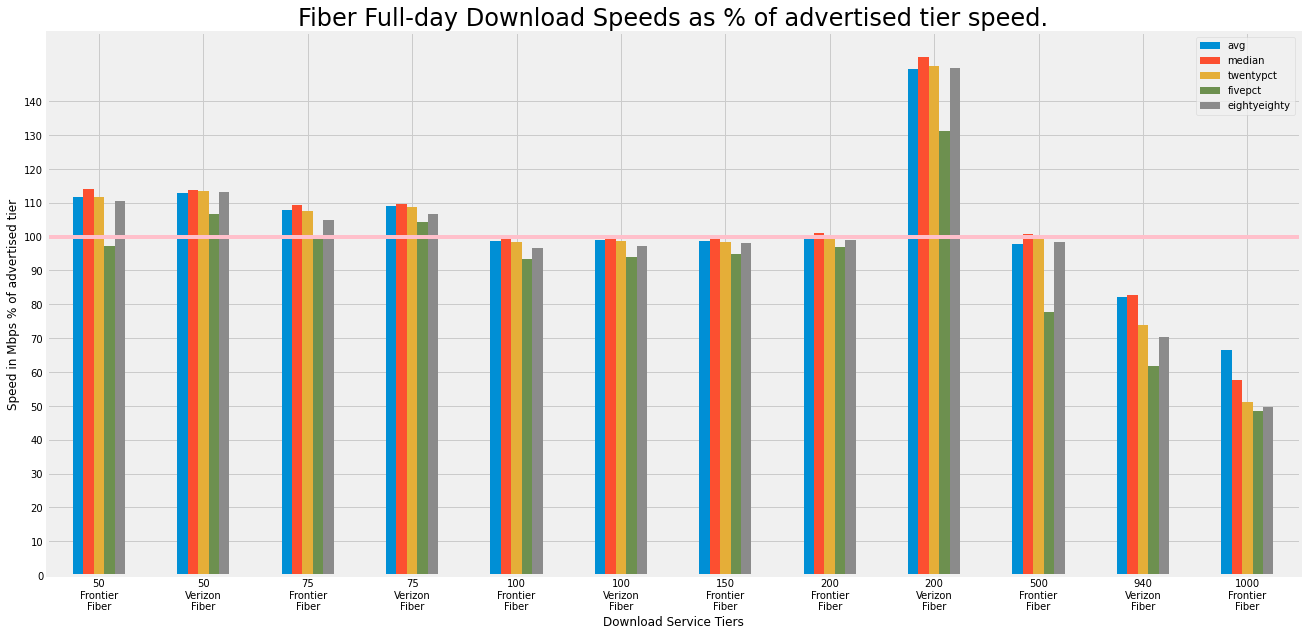

In [27]:
chartData = normDFiber

ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 150, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Download Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Full-day Download Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

<hr>

<h3> Upload Speed Charts

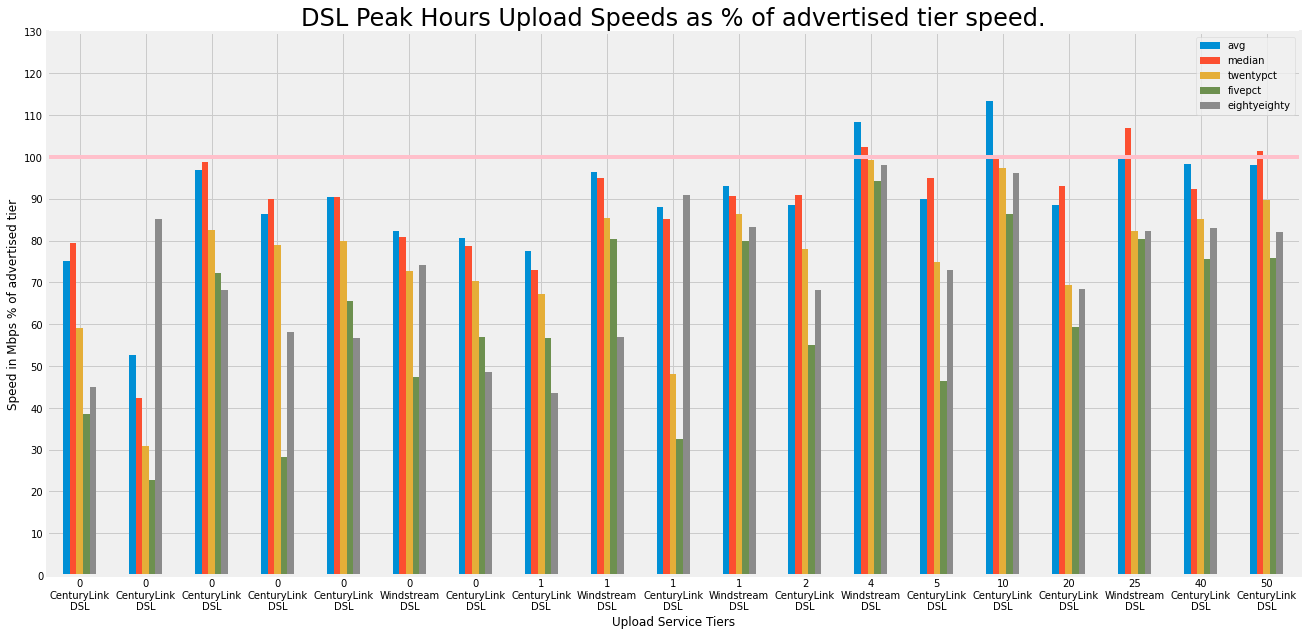

In [28]:
chartData = peakUDSL



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

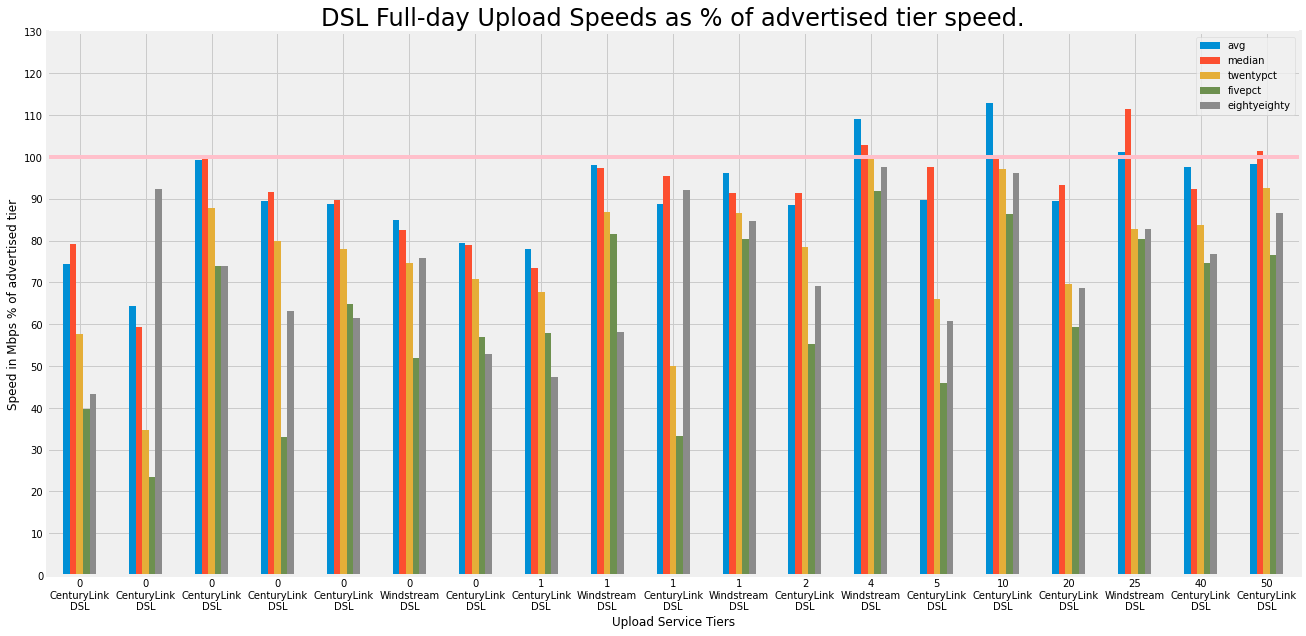

In [29]:
chartData = normUDSL



ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('DSL Full-day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

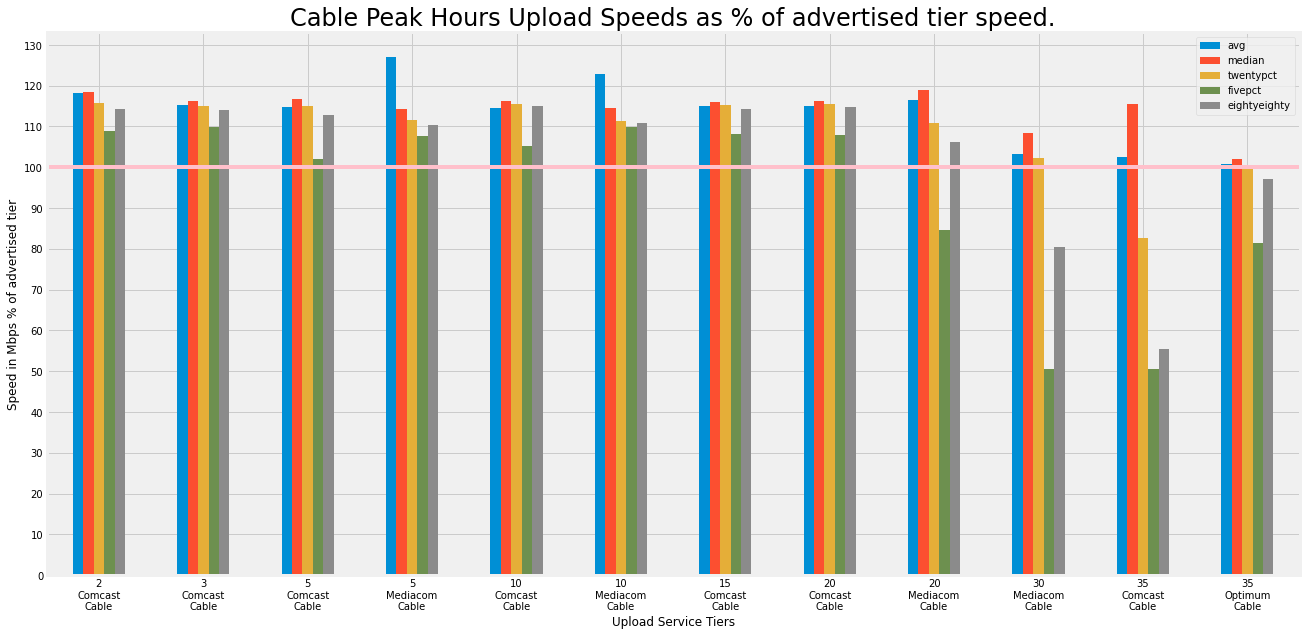

In [30]:
chartData = peakUCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

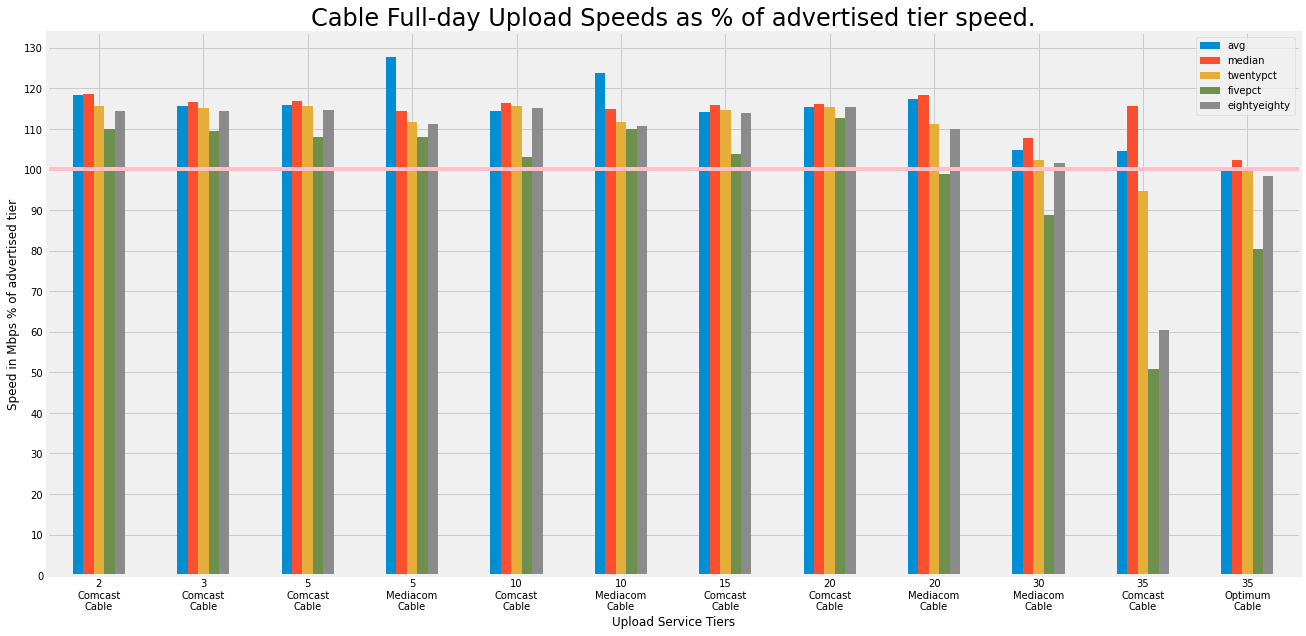

In [31]:
chartData = normUCable


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 140, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Cable Full-day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

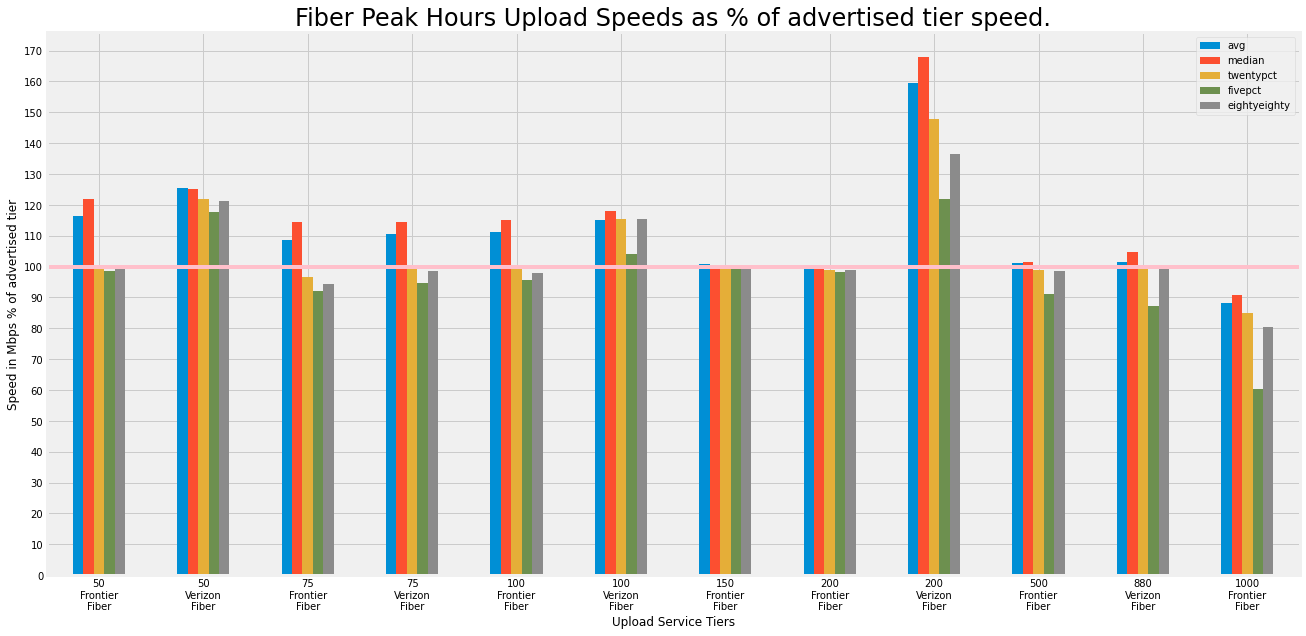

In [32]:
# chartData = peakUChart
# chartData = chartData[chartData.tier > 20]
# chartData = chartData[chartData.tier <= 100]

chartData = peakUFiber


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 180, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Peak Hours Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()

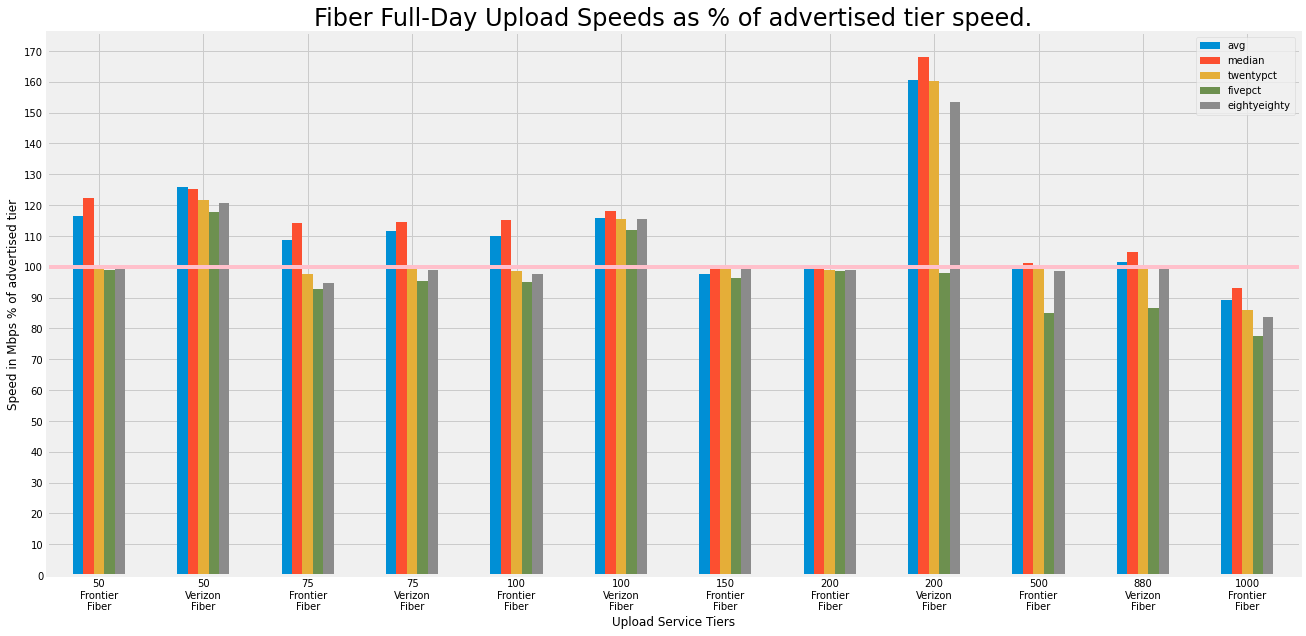

In [33]:

chartData = normUFiber


ax = chartData.plot(x = "ispTech", y = ['avg', 'median', 'twentypct', 'fivepct', 'eightyeighty'],  kind = 'bar', stacked = False, 
                   fontsize = 10, rot = 0, figsize = (20,10), grid = True)


plt.yticks(np.arange(0, 180, 10))
plt.axhline(y = 100, color = 'pink', linestyle = '-')


ax.set_xlabel('Upload Service Tiers')
ax.set_ylabel('Speed in Mbps % of advertised tier')
ax.set_title('Fiber Full-Day Upload Speeds as % of advertised tier speed.', fontsize=24)


plt.show()